In [1]:
import torch
import time
from sfutils.utils import generate_mask, load_model, writeDACFile, sample_top_n, hotsequence
from dataloader.dataset import CustomDACDataset
from sfutils.utils import interpolate_vectors, breakpoints, breakpoints_classseq


import os
import yaml

from DACTransformer.RopeCondDACTransformer import RopeCondDACTransformer

import numpy as np
import matplotlib.pyplot as plt

import dac
import soundfile as sf
import IPython.display as ipd

# this is for the little magic that generates markdown text and opens a markdown cell!
from IPython.display import display, Markdown
import IPython


from sfutils.saveExpForNotebook import savefordiary

<div style="width: 100%; height: 20px; background-color: black;"></div>

## Parameters

In [2]:
## params ##########################################################
# set this to whatever you called the experiment in the top of your params.yaml file.
experiment_name= "sm_mel_test" #"sm_mel_test"#"mini_mel_test" 
# probably don't change this is the default, set in the params.yaml file.
checkpoint_dir = 'runs' + '/' + experiment_name  

cptnum =  4000 # (the checkpoint number must be in the checkpoint directory)
SAVEWAV=True
DEVICE='cuda' #######''cuda'
gendur=10 #how many seconds you wnat your output sound to be
topn=100 # sample from the top n logits


###########################################################################
#  Choose a breakpoint sequence (and/or make one yourself) ...
###########################################################################
#morphname='conditioning'  ###   (choose from breakpoint sets defined below)
#morphname='sweep'  ###   (choose from breakpoint sets defined below)
#morphname='0.1.overlap'
#morphname='0.1.overlap'
#morphname='pitchseq'
morphname='conditioning'

<div style="width: 100%; height: 20px; background-color: black;"></div>

### Read Paramfile and get class list

In [3]:
#any config.yaml files used for training are copied to the checkpoint directory as "params.yaml"
paramfile = checkpoint_dir + '/' +  'params.yaml' 
print(f"will use paramfile= {paramfile}") 
# Load YAML file
with open(paramfile, 'r') as file:
    params = yaml.safe_load(file)

# Create an instance of the dataset
data_dir = params['data_dir']
data_frames =  params['data_frames']
ftype = params['ftype'] #dac or mel

dataset = CustomDACDataset(data_dir=data_dir, metadata_excel=data_frames, ftype=ftype, transforms=None)

num_cond_classes = dataset.get_num_classes() # 0
num_cond_params = dataset.get_num_params()
cond_size = num_cond_classes + num_cond_params # num_classes + num params - not a FREE parameter!
classnames=dataset.get_class_names()
paramnames=dataset.get_param_names()
allcondnames=classnames+paramnames
print(f'Dataset has for conditioning {num_cond_classes} classes and {num_cond_params} parameters.')
print(f'class names are {classnames} and param names are {paramnames}')
print(f'allcondnames are {allcondnames}')

#For your reference:
#Print the list of all classes
print(f'classnames={classnames}')
print(f' ------- One hot vectors for classes ----------')
for i in range(len(classnames)):
    print(f' {classnames[i]} : \t{dataset.onehot(classnames[i])}')

will use paramfile= runs/sm_mel_test/params.yaml
 in get_sequence_length, data.shape is torch.Size([1, 128, 430])
Dataset has for conditioning 4 classes and 1 parameters.
class names are ['DSApplause', 'DSBugs', 'DSPistons', 'DSWind'] and param names are ['Param1']
allcondnames are ['DSApplause', 'DSBugs', 'DSPistons', 'DSWind', 'Param1']
classnames=['DSApplause', 'DSBugs', 'DSPistons', 'DSWind']
 ------- One hot vectors for classes ----------
 DSApplause : 	tensor([1., 0., 0., 0.])
 DSBugs : 	tensor([0., 1., 0., 0.])
 DSPistons : 	tensor([0., 0., 1., 0.])
 DSWind : 	tensor([0., 0., 0., 1.])


In [4]:
###########################################################################
#  These first four just explore the parameter range for each class used for training ...
###########################################################################
morphs={}

# Create a 'breakpoint' param sweep from 0 upt to 1 and back for a class (just change the index for different classes)
#---------------------------------------------------------------------------------
# Sweep a parameter up and down for one class
if 0 : # need to have at least one parameter
    morphs['sweep']={
        'vsequence' : breakpoints(classnames + paramnames, 
                                         **{classnames[0] : [1,1,1,1,1,1]}, # a keyword dictionary to use a string as a key!
                                         # DSBugs = [1,1,1,1,1,1],   # this works, too, if you prefer
                                         **{paramnames[0] : [0,0,1,1,0,0]}
                                 ),
        'vtimes' : [0,.1, .4, .6, .9, 1]
    }

#----------------------------------------------------------------------------------
# Create a sequence 'breakpoints' that steps through each class giving each an equal amount of time over the duration
# All parmeters are set to their middle value
morphs['conditioning']=breakpoints_classseq(classnames, [.5 for p in paramnames])
#morphs['conditioning']=breakpoints_classseq(classnames, [0.22 if i == 0 else 1 if i == 6 else 0 for i in range(len(paramnames))])

#----------------------------------------------------------------------------------
# this is specific to nsynth data with one-hot pitches
baselist=[0] * cond_size  # list of default values for all conditionig values
baselist[:3] = [0,1,1] # lisf of value to hold constant
morphs['hotseq']=hotsequence(baselist , list(range(3,cond_size)), 1) # ccycle 1's through these indexes

#----------------------------------------------------------------------------------
# Morph over a vectors in vsequence lineary for (noramlized) time steps vtimes. Create your sequence explicitly"
# It might be easier to use breakpoints() as above to create this morph
# Don't specify classes that you don't have on the list!
print(f'len(classnames) = {len(classnames)}')
if len(classnames) > 1 and len(paramnames) >1:
    morphs['0.1.overlap'] = {
        'vsequence' : breakpoints(classnames+paramnames,
                                  **{classnames[0] : [1,1,1,1,0,0]},
                                  **{classnames[1] : [0,0,1,1,1,1]},
                                  **{paramnames[0]: [.5,.5,.5,.5,.5,.5]}),
        'vtimes' : [0,.2,.4,.6,.8, 1] # must be the same length as the number of break points in vsequence
    }

#----------------------------------------------------------------------------------
# Create your sequence explicitly"
# Just set class and param values at half-mast and run for the whole length of time 
# Vectors must be the proper length - num classes + num parameters!!!!!! 
# note: each column corresponds to a class value. Rows correspond to vtimes. 

morphs['allmid'] = {
    'vsequence': [
        torch.tensor([0.5 for p in classnames + paramnames]),
        torch.tensor([0.5 for p in classnames + paramnames])
    ],
    'vtimes': [0,1] # must be the same length as the number of break points in vsequence
}

#----------------------------------------------------------------------------------
# Create your sequence explicitly"
# This is just my personal one for creating a sequence of pitches on a major scale with my training parameter. 
if 0:
    if len(paramnames) >=1:
        morphs['pitchseq'] = {
            'vsequence' : breakpoints(classnames+paramnames,
                                      **{classnames[0] : [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]}, 
                                      #**{classnames[1] : [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]},
                                      **{paramnames[0]: [0.00, 0.00, 0.17, 0.17, 0.33, 0.33, 0.42, 0.42, 0.58, 0.58,  0.75, 0.75, 0.92, 0.92, 1.00, 1.00]},
                                      amp = [.56, .56, .56, .56, .56, .56, .56, .56, .56, .56,  .56, .56, .56, .56, .56, .56]
                                     ),
            'vtimes' : [0.00, 0.12, 0.12, 0.25, 0.25, 0.38, 0.38, 0.50, 0.50, 0.62, 0.62, 0.75, 0.75, 0.88, 0.88, 1.00] # must be the same length as the number of break points in vsequence
        }
    

#====================================================================================
#print out your chosen morph breakpoints
morphs[morphname]

len(classnames) = 4


{'vsequence': [tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.5000]),
  tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.5000]),
  tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.5000]),
  tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.5000]),
  tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.5000]),
  tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.5000]),
  tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.5000]),
  tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.5000])],
 'vtimes': [0, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 1]}

Morph over a vectors in vsequence lineary for (noramlized) time steps vtimes. Create your sequence:

### <font color='blue'> Derived parameters  </font>

In [5]:
# Get parameters from yaml file and derive any necessary
######################################################
verbose=0
inference_steps=86*gendur  #86 frames per second
    
TransformerClass =  globals().get(params['TransformerClass'])  
print(f"using TransformerClass = {params['TransformerClass']}") 
print(f' and TransformerClass is class object {TransformerClass}')

### embed_size = params['tblock_input_size'] -cond_size # 240 #32  # embed_size must be divisible by num_heads and by num tokens
embed_size = params['model_size'] # 240 #32  # embed_size must be divisible by num_heads and by num tokens
print(f'embed_size is {embed_size}')

fnamebase='out' + '.e' + str(embed_size) + '.l' + str(params['num_layers']) + '.h' + str(params['num_heads']) + '_chkpt_' + str(cptnum).zfill(4) 
checkpoint_path = checkpoint_dir + '/' +  fnamebase  + '.pth' 

# for saving sound 
outdir=checkpoint_dir
outfname=outdir+"/"+ "dacs" + "/" +  morphname + '_chkpt_' + str(cptnum).zfill(4) +  "_steps_"+str(inference_steps).zfill(4) +'.topn_'+ f"{topn:04d}"
paramplotfname = outfname + "_params.jpg"
sfmelplotfname = outfname + "_sfmel.jpg"
os.makedirs(outfname, exist_ok=True)

print(f'checkpoint_path = {checkpoint_path}, fnamebase = {fnamebase}' )

using TransformerClass = RopeCondDACTransformer
 and TransformerClass is class object <class 'DACTransformer.RopeCondDACTransformer.RopeCondDACTransformer'>
embed_size is 128
checkpoint_path = runs/sm_mel_test/out.e128.l2.h8_chkpt_4000.pth, fnamebase = out.e128.l2.h8_chkpt_4000


In [6]:
if DEVICE == 'cuda' :
    torch.cuda.device_count()
    torch.cuda.get_device_properties(0).total_memory/1e9

    device = torch.device(DEVICE) # if the docker was started with --gpus all, then can choose here with cuda:0 (or cpu)
    torch.cuda.device_count()
    print(f'memeory on cuda 0 is  {torch.cuda.get_device_properties(0).total_memory/1e9}')
else :
    device=DEVICE
device

memeory on cuda 0 is  25.37816064


device(type='cuda')

# The inference method

In [7]:
 
def inference(model, inference_cond, Ti_context_length, vocab_size, num_tokens, inference_steps, topn, fname) :
    model.eval()
    mask = generate_mask(Ti_context_length, Ti_context_length).to(device)

    print(f'In inference, the shape of the mask is {mask.shape}')
    print(f'In inference, the shape of the inference_cond passed in is  {inference_cond.shape}')

    # The "input data" is random with a sequence length equal to the context length (and the mask) which is used 
    # to generate the first step of the output.It is not included in the output.
    input_data = torch.randint(0, vocab_size, (1, Ti_context_length, num_tokens)).to(device)  # Smaller context window for inference
    print(f'==========Shape of inpt data is {input_data.shape}')
    #Extend the first conditional vector to cover the "input" which is of length Ti_context_length
    inference_cond = torch.cat([inference_cond[:, :1, :].repeat(1, Ti_context_length, 1), inference_cond], dim=1)
    predictions = []

    print(f' In inference, the shape of input_data (context window) is {input_data.shape}')
    print(f'In inference, the shape of the inference_cond After extending to cover priming input, is  {inference_cond.shape}')
    
    t0 = time.time()
    for i in range(inference_steps):  # 
        if cond_size == 0:
            output = model(input_data, None, mask) # step through 
        else : 
            #step window through conditioning input
            output = model(input_data, inference_cond[:, i:Ti_context_length+i, :], mask) # step through

        # This takes the last vector of the sequence (the new predicted token stack) so has size(b,steps,4,1024)
        # This it takes the max across the last dimension (scores for each element of the vocabulary (for each of the 4 tokens))
        # .max returns a duple of tensors, the first are the max vals (one for each token) and the second are the
        #        indices in the range of the vocabulary size. 
        # THAT IS, the selected "best" tokens (one for each codebook) are taken independently
        ########################### next_token = output[:, -1, :, :].max(-1)[1]  # Greedy decoding for simplicity
        
        next_token = sample_top_n(output[:, -1, :, :],topn) # topn=1 would be the same as max in the comment line above    
        predictions.append(next_token)
        input_data = torch.cat([input_data, next_token.unsqueeze(1)], dim=1)[:, 1:]  # Slide window

    t1 = time.time()
    inf_time = t1-t0
    print(f'inference time for {inference_steps} steps, or {inference_steps/86} seconds of sound is {inf_time}' )

    dacseq = torch.cat(predictions, dim=0).unsqueeze(0).transpose(1, 2)
    if mask == None:
        writeDACFile(fname + '_unmasked', dacseq)
    else :
        writeDACFile(fname, dacseq)   

    return dacseq

    print(f'dacseq shape written to file is of shape {dacseq.shape}')

In [8]:
def inferenceMEL(model, inference_cond, Ti_context_length, vocab_size, num_tokens, inference_steps, topn, fname) :
    model.eval()
    mask = generate_mask(Ti_context_length, Ti_context_length).to(device)

    print(f'In inference, the shape of the mask is {mask.shape}')
    print(f'In inference, the shape of the inference_cond passed in is  {inference_cond.shape}')

    # The "input data" is random with a sequence length equal to the context length (and the mask) which is used 
    # to generate the first step of the output.It is not included in the output.
    input_data = torch.rand((1, Ti_context_length, num_tokens*vocab_size)).to(device)  # Smaller context window for inference
    #print(f'==========Shape of inpt data is {input_data.shape}')
    #Extend the first conditional vector to cover the "input" which is of length Ti_context_length
    inference_cond = torch.cat([inference_cond[:, :1, :].repeat(1, Ti_context_length, 1), inference_cond], dim=1)
    predictions = []

    #print(f' In inference, the shape of input_data (context window) is {input_data.shape}')
    #print(f'In inference, the shape of the inference_cond After extending to cover priming input, is  {inference_cond.shape}')
    
    t0 = time.time()
    for i in range(inference_steps):  # 
        # print(f'PASSING model input_data.dtype = {input_data.dtype}')
        if cond_size == 0:
            output = model(input_data, None, mask) # step through 
        else : 
            #step window through conditioning input
            output = model(input_data, inference_cond[:, i:Ti_context_length+i, :], mask) # step through

        # This takes the last vector of the sequence (the new predicted token stack) so has size(b,steps,4,1024)
        # This it takes the max across the last dimension (scores for each element of the vocabulary (for each of the 4 tokens))
        # .max returns a duple of tensors, the first are the max vals (one for each token) and the second are the
        #        indices in the range of the vocabulary size. 
        # THAT IS, the selected "best" tokens (one for each codebook) are taken independently
        ########################### next_token = output[:, -1, :, :].max(-1)[1]  # Greedy decoding for simplicity
        #print(f'OUTPUT shape is {output.shape}')
        predictions.append(output[:, -1, :, :])
        input_data = torch.cat([input_data, output[:, -1, :, :]], dim=1)[:, 1:]  # Slide window

    t1 = time.time()
    inf_time = t1-t0
    print(f'inference time for {inference_steps} steps, or {inference_steps/86} seconds of sound is {inf_time}' )
    print(f'Predicted spectrogram has length = {len(predictions)}, of tensor of shape {predictions[0].shape}')
    
    melseq  = torch.cat(predictions, dim=1).squeeze(0).permute(1, 0)  # Shape: [v, t]
    # melseq  = torch.stack(predictions, dim=0).squeeze(2).permute(1, 2, 0) # Shape: [1, v, t] for BigVGAN saving
    print(f'melseq shape is {melseq.shape}')

    return melseq
    
    # if mask == None:
    #     writeDACFile(fname + '_unmasked', dacseq)
    # else :
    #     writeDACFile(fname, dacseq)   

    # print(f'dacseq shape written to file is of shape {dacseq.shape}')

In [9]:

#Load the stored model
model, _, Ti_context_length, vocab_size, num_codebooks, cond_size = load_model(checkpoint_path,  TransformerClass, DEVICE, verbose=verbose)

print(f'Mode loaded, context_length (Ti_context_length) = {Ti_context_length}')
# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {num_params}')

model.to(device);

MultiEmbedding : input_type = float
Initializing MultiEmbedding with vocab_size_or_input_dim=128, embed_dim = 128, and num_tokens = 1
Mode loaded, context_length (Ti_context_length) = 86
Total number of parameters: 381696


/home/lonce/working/working/dacsynthformer/sfutils/utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_tensors = [torch.tensor(vec) for vec in v]


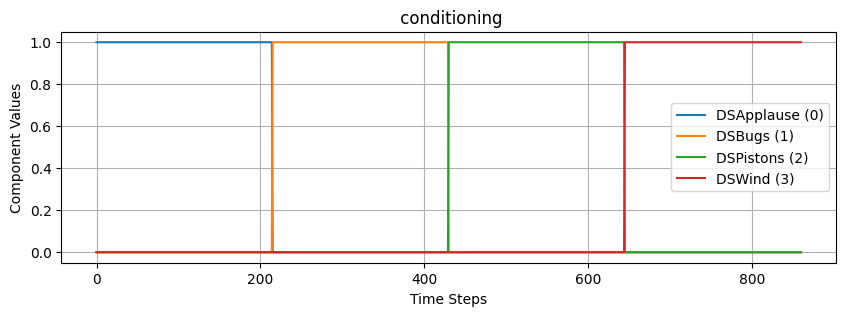

shape of inf_cond is  = torch.Size([1, 861, 5])
Done


In [10]:
# Generate the conditioning sequence from the breakpoint sequence, and plot the trajectories

if cond_size == 0 :
    inference_cond = None
else : 

    inference_cond=interpolate_vectors(morphs[morphname]['vsequence'], [round(x * inference_steps) for x in morphs[morphname]['vtimes']]) #length must cover staring context window+inf steps

    # Make a plot of any changing parmaeters --------------------------------------------------------------
    # Extract the 2D array of shape [n, m]
    data = inference_cond[0]
    # Find components that change over time
    changing_indices = [i for i in range(cond_size) if not torch.all(data[:, i] == data[0, i])]

    # Plot the changing components
    plt.figure(figsize=(10, 3))

    for i in changing_indices:
        if i < len(classnames) :
            plt.plot(data[:, i], label=f'{dataset.int2classname[i]} ({i})')
        else : 
            plt.plot(data[:, i], label=f'Param: {allcondnames[i]}', linestyle='--')

    plt.xlabel('Time Steps')
    plt.ylabel('Component Values')
    plt.title(f' {morphname}')
    plt.legend()
    plt.grid(True)

    if SAVEWAV :  
        plt.savefig(paramplotfname, format="jpg")
    # Create a figure and axis
    plt.show()

    inference_cond=inference_cond.to(device)
    print(f'shape of inf_cond is  = {inference_cond.shape}') 
 
print('Done')


<div style="width: 100%; height: 20px; background-color: black;"></div>

# Run the Transformer to generate the .dac file

In [11]:
#outfname=outdir+"/"+ "dacs" + "/" +  morphname + '_chkpt_' + str(cptnum).zfill(4) +  "_steps_"+str(inference_steps).zfill(4) +'.topn_'+ f"{topn:04d}"
print(f'outfname is {outfname}')

if ftype == 'dac' :
    inference(model, inference_cond, Ti_context_length, vocab_size, num_codebooks, inference_steps, topn, outfname ) 

if ftype == 'mel' :
    melseq = inferenceMEL(model, inference_cond, Ti_context_length, vocab_size, num_codebooks, inference_steps, topn, outfname ) 


outfname is runs/sm_mel_test/dacs/conditioning_chkpt_4000_steps_0860.topn_0100
In inference, the shape of the mask is torch.Size([86, 86])
In inference, the shape of the inference_cond passed in is  torch.Size([1, 861, 5])
inference time for 860 steps, or 10.0 seconds of sound is 1.130262851715088
Predicted spectrogram has length = 860, of tensor of shape torch.Size([1, 1, 128])
melseq shape is torch.Size([128, 860])


<div style="width: 100%; height: 20px; background-color: black;"></div>

# Decode the transformer-generated tokens to audio

In [12]:
# Get the trained encodec from Descript
# The first time you do this, it can take a while. Go get coffee. After that, it uses a cached version
if ftype == 'dac' :
    dacmodel_path = dac.utils.download(model_type="44khz") 
    print(f'The DAC decoder is in {dacmodel_path}')
    with torch.no_grad():
        dacmodel = dac.DAC.load(dacmodel_path)
    
        dacmodel.to(device); #wanna see the model? remove the semicolon
        dacmodel.eval();  # need to be "in eval mode" in order to set the number of quantizers
    

In [13]:
# ------------------------------- 
# --------  Draw the spectrogram 
# ------------------------------- 
if ftype == 'dac':
    selected_file=outfname + ".dac"
    print(f' selected_file is {selected_file}')
    
    with torch.no_grad():
        dacfile = dac.DACFile.load(selected_file)
        # FIRST - Decompress it back to an AudioSignal\ from codes to z (1024) to signal   
        print(f'dacfile.codes shape is: {dacfile.codes.shape}')
        t0=time.time()
        asig=dacmodel.decompress(dacfile)
        t1=time.time()
        inf_time = t1-t0
        print(f'decompress time for {asig.audio_data.shape[2]/44100} seconds of sound is {inf_time}' )
        print(f'asig.audio_data.shape[2] is {asig.audio_data.shape[2]}')
        
        asig.cpu().widget()
        asig.audio_data.shape
        adata = asig.samples.view(-1).numpy()

    if SAVEWAV :  
        sf.write(outfname + ".wav", adata, 44100)
        #asig.save_image(outfname + ".jpg")
        #print(f'saving .wav and .jpgs to outfname {outfname}')

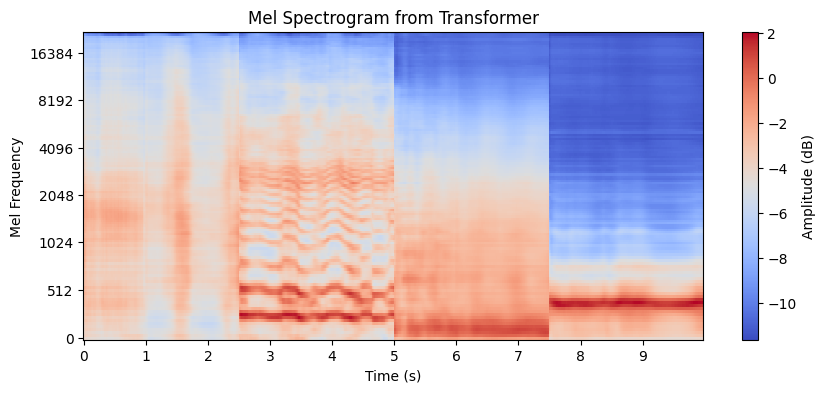

Loading config.json from local directory


/home/lonce/miniconda3/envs/dacformer2/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Loading weights from local directory


In [17]:
# ------------------------------- 
# --------  Draw the spectrogram 
# ------------------------------- 
import sys
# Get the absolute path of the subdirectory
subdir_path = os.path.abspath("BigVGAN")  # Update with actual path

# Add it to sys.path
if subdir_path not in sys.path:
    sys.path.append(subdir_path)
    
import bigvgan
import librosa
from meldataset import get_mel_spectrogram




%matplotlib inline
if ftype == 'mel':
    mel_spec = melseq.detach().cpu().numpy()
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=44100, hop_length=512, x_axis="time", y_axis="mel")
    plt.colorbar(label="Amplitude (dB)")
    plt.title("Mel Spectrogram from Transformer")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.savefig(sfmelplotfname, format="jpg", bbox_inches='tight')

    plt.show()


    bvgmodel = bigvgan.BigVGAN.from_pretrained('BigVGAN/bigvgan_v2_44khz_128band_512x', use_cuda_kernel=False).to(device)
    # bvgmodel = bigvgan.BigVGAN.from_pretrained('nvidia/bigvgan_v2_44khz_128band_512x', use_cuda_kernel=False)
    
    with torch.inference_mode():
        wav_gen = bvgmodel(melseq.unsqueeze(0).to(device)) # wav_gen is FloatTensor with shape [B(1), 1, T_time] and values in [-1, 1]
    wav_gen_float = wav_gen.squeeze(0).to('cpu') # wav_gen is FloatTensor with shape [1, T_time]
    adata = wav_gen_float.squeeze().numpy()

    # plt.figure(figsize=(10, 4))
    # librosa.display.waveshow(adata, sr=44100)
    # plt.xlabel("Time (seconds)")
    # plt.ylabel("Amplitude")
    # plt.title("Waveform")
    # plt.show()

In [18]:
# Audio display
# plt.plot(adata)
# Audio player
ipd.Audio(adata, rate=44100) 

In [19]:
if SAVEWAV  : 
    # savefordiary sound, param image, spectrogram, and param file to research diary
    #diarydir="/home/lonce/DIARY/CommonDiary/media/deleteme"
    diarydir="deleteme/"+ experiment_name +  "_" + morphname
    md_text, displaypath = savefordiary(adata, paramplotfname, sfmelplotfname, checkpoint_dir, diarydir, experiment_name, paramfile)
    # display the markdown text in the output of this cell!!
    display(Markdown(md_text))

Saved loss plot as deleteme/sm_mel_test_conditioning/sm_mel_test_loss.jpg

deleteme/sm_mel_test_conditioning/sm_mel_test<br>
<img width="600" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test_params.jpg">  <br>
<img width="640" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test_sfmel.jpg">  <br>
<img width="550" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test_waveform.jpg">  <br>
<img width="640" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test.jpg">  <br>
<audio src="deleteme/sm_mel_test_conditioning/sm_mel_test.wav" controls>alternative text</audio>  <br>
<img width="600" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test_loss.jpg">  <br>
<a href="deleteme/sm_mel_test_conditioning/params.yaml">paramfile link</a>




deleteme/sm_mel_test_conditioning/sm_mel_test<br>
<img width="600" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test_params.jpg">  <br>
<img width="640" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test_sfmel.jpg">  <br>
<img width="550" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test_waveform.jpg">  <br>
<img width="640" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test.jpg">  <br>
<audio src="deleteme/sm_mel_test_conditioning/sm_mel_test.wav" controls>alternative text</audio>  <br>
<img width="600" height="500" src="deleteme/sm_mel_test_conditioning/sm_mel_test_loss.jpg">  <br>
<a href="deleteme/sm_mel_test_conditioning/params.yaml">paramfile link</a>


In [ ]:
baselist=[0] * cond_size
baselist[:3] = [1,0,1]
foo = hotsequence(baselist , list(range(3,cond_size)), 1)
#foo = breakpoints_classseq(classnames, [0.22 if i == 0 else 1 if i == 6 else 0 for i in range(len(paramnames))])
foo